<a href="https://colab.research.google.com/github/EdoardoMorucci/Plant-Leaves-Search-Engine---MIRCV/blob/main/model_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This notebook describes the fine-tuning process of Convolutional Neural Network using as Base Network DenseNet

# Local download of the dataset

In [ ]:
! pip install -q kaggle

from google.colab import files
_ = files.upload()

! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d davidedemarco/healthy-unhealthy-plants-dataset-segmented --unzip

 99% 633M/642M [00:13<00:00, 63.2MB/s]
100% 642M/642M [00:13<00:00, 50.3MB/s]


# Connection to Google Drive

In [26]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Import

In [35]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.metrics import ConfusionMatrixDisplay

# Data Preparation


The dataset is on Google Drive and the dataset directory has the structure:

```
dataset/
  class_1/
    image_1.jpg
    image_2.jpg
    ...
  class_2/
    image_3.jpg
    image_4.jpg
    ...
  ...
  ...
  class_n/
    ...
```

To train and test the model, we need three subsets: train, test and validation. To split the dataset, we use the [split-folder](https://pypi.org/project/split-folders/) package.

In [ ]:
!pip install split-folders tqdm

We need to check if the hardware accelaration is enabled, since training a CNN on a CPU could be infeasible.

In [28]:
#check hardware acceleration
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


We define the costants with the directory of the dataset and the directory where the datasplits are created. In addition we define the image size and the batch size.

In [29]:
BASE_DIR = "gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/"
DATA_DIR = '/content/Healthy & Unhealthy Plants Dataset Segmented'
SETS_DIR = '/content/healthy-unhealthy-plants-sets'
MODEL_DIR = '/content/model'

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
N_CLASSES = 14

We need to create data splits. The dataset will be divided 80% in training set, 10% in validation set and 10% in test set.

In [ ]:
import splitfolders
# split data
splitfolders.ratio(DATA_DIR, output=SETS_DIR, seed=123, ratio=(0.8, 0.1, 0.1), group_prefix=None)


Copying files: 0 files [00:00, ? files/s]
Copying files: 345 files [00:00, 3447.74 files/s]
Copying files: 764 files [00:00, 3884.06 files/s]
Copying files: 1306 files [00:00, 4584.73 files/s]
Copying files: 1780 files [00:00, 4645.98 files/s]
Copying files: 2245 files [00:00, 4093.58 files/s]
Copying files: 2709 files [00:00, 4262.91 files/s]
Copying files: 3144 files [00:00, 4027.60 files/s]
Copying files: 3554 files [00:00, 3591.53 files/s]
Copying files: 3958 files [00:01, 3711.44 files/s]
Copying files: 4459 files [00:01, 3529.29 files/s]
Copying files: 4943 files [00:01, 3865.16 files/s]
Copying files: 5488 files [00:01, 4288.61 files/s]
Copying files: 6059 files [00:01, 4682.13 files/s]
Copying files: 6606 files [00:01, 4905.43 files/s]
Copying files: 7108 files [00:01, 4888.37 files/s]
Copying files: 7610 files [00:01, 4923.94 files/s]
Copying files: 8109 files [00:01, 4560.85 files/s]
Copying files: 8651 files [00:01, 4799.48 files/s]
Copying files: 9168 files [00:02, 4903.98

Now we need to create the Dataset objects from the sets directory. We use the [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) function provided by Keras. An example of use of this library can be found on the official documentation provided by Keras ([here](https://keras.io/examples/vision/image_classification_from_scratch/)).

In [40]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    SETS_DIR + '/train',
    labels='inferred', #the label of the dataset is obtained by the name of the directory
    seed=123,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    SETS_DIR + '/val',
    labels='inferred', #the label of the dataset is obtained by the name of the directory
    seed=123,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    SETS_DIR + '/test',
    labels='inferred', #the label of the dataset is obtained by the name of the directory
    seed=123,
    shuffle=False,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)


Found 57623 files belonging to 14 classes.
Found 7195 files belonging to 14 classes.
Found 7216 files belonging to 14 classes.


The images needs to be preprocessed before going in input to the CNN DenseNet. We use the function [tf.keras.applications.densenet.preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/densenet/preprocess_input) to preprocess the image.

In [41]:
def preprocess(images, labels):
  images = tf.keras.applications.densenet.preprocess_input(images)
  return images, labels
  
#preprocessing of the images in all the set
train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

# Training

The CNN used has base network is DenseNet. Since we want to fine-tune the network. We remove the fully-connected layer on top and later we will add an output layer with 14 neurons (1 for each class we want to predict).

In [ ]:
pretrained_model = tf.keras.applications.DenseNet121(
    input_shape = (224, 224, 3),
    weights="imagenet",
    include_top=False,  # do not include the pretrained layers implementing the imagenet classifier
)

# freezes weights of all levels of the pre-trained network
pretrained_model.trainable = False 

#pretrained_model.summary()

On top of the base network we apply global average pooling and we add an hidden classifier with 256 neurons. The last layer of the network is the output classification layer, with 1 neuron for each class and with softmax as activation function.

In [ ]:
from tensorflow.keras import layers as L

x = pretrained_model.output

# add a global average pooling
x = L.GlobalAveragePooling2D(name='gap')(x)
x = L.Flatten(name='flatten')(x)

# add a fully-connected layer (Dense) of 256 neurons with name='classifier_hidden'
x = L.Dense(256,activation='relu', name='classifier_hidden')(x)

# add output classification layer with n_classes outputs and softmax activation
x = L.Dense(N_CLASSES, activation='softmax')(x)
new_output = x

model = tf.keras.models.Model(inputs=pretrained_model.input, outputs=new_output, name='healthy_and_unhealty_plants_classifier')

#model.summary()

To prevent huge gradients coming from the newly initialized layers from destroying the weights in the pretrained layers  we will initially freeze the layers of the base network and train only new layers. As optimizers we use Adam. We implemented early stoppings in order to terminate the process if the loss on the validation set doesn't improve for two consecutive epochs.

In [ ]:
learning_rate=0.005
epochs=20

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer,
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])
callbacks = [
  # early stopping
      tf.keras.callbacks.EarlyStopping(
          monitor='val_loss', 
          patience=2,
          restore_best_weights=True),

  # checkpoint best model 
  tf.keras.callbacks.ModelCheckpoint(
    filepath=MODEL_DIR + "/healthy_and_unhealty_plants_classifier",
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True
  ),
]

train_ds_shuffle = train_ds.shuffle(123)  # shuffles data each epoch

# train the model
history = model.fit(
  train_ds_shuffle,
  validation_data=val_ds,
  epochs = epochs,  
  callbacks=callbacks,
  batch_size=BATCH_SIZE,
  verbose=1
)


Epoch 1/20
901/901 [==============================] - 480s 480ms/step - loss: 0.1345 - accuracy: 0.9609 - val_loss: 0.0915 - val_accuracy: 0.9662
Epoch 2/20
901/901 [==============================] - 404s 430ms/step - loss: 0.0465 - accuracy: 0.9851 - val_loss: 0.0317 - val_accuracy: 0.9883
Epoch 3/20
901/901 [==============================] - 402s 428ms/step - loss: 0.0403 - accuracy: 0.9869 - val_loss: 0.1378 - val_accuracy: 0.9654
Epoch 4/20
901/901 [==============================] - 402s 429ms/step - loss: 0.0380 - accuracy: 0.9884 - val_loss: 0.0606 - val_accuracy: 0.9815


In [ ]:
model.summary()

In [ ]:
model.save('/content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/model_unfine_tuned')

INFO:tensorflow:Assets written to: /content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/model_unfine_tuned/assets


Now we need to unfreeze layers of the base network and reperforms training in order to fine-tune the network. Since this operation is very expensive in terms of resources, we decided to unfreeze only the last two blocks of the network. As we cans see from the output of the next cell, the number of traainable parameters of the network increased from 265,998 to 589,582 

In [ ]:
trainable = False
for layer in model.layers:
    if layer.name == 'conv5_block15_0_bn':
        trainable = True
    is_bn = layer.name.endswith('bn')  # keep BatchNorm freezed, good practice for finetuned models
    if not is_bn:
      layer.trainable = trainable

model.summary()

Now we perform fine-tuning.

In [ ]:
learning_rate = 0.005
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer,
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

# train the model
history = model.fit(
  train_ds_shuffle,
  validation_data=val_ds,
  epochs = epochs,  
  callbacks=callbacks,
  batch_size=BATCH_SIZE,
  verbose=1
)

Epoch 1/20
901/901 [==============================] - 420s 438ms/step - loss: 0.2922 - accuracy: 0.9822 - val_loss: 0.0533 - val_accuracy: 0.9829
Epoch 2/20
901/901 [==============================] - 410s 437ms/step - loss: 0.0229 - accuracy: 0.9922 - val_loss: 0.0283 - val_accuracy: 0.9907
Epoch 3/20
901/901 [==============================] - 410s 437ms/step - loss: 0.0220 - accuracy: 0.9930 - val_loss: 0.0371 - val_accuracy: 0.9875
Epoch 4/20
901/901 [==============================] - 410s 437ms/step - loss: 0.0286 - accuracy: 0.9904 - val_loss: 0.0357 - val_accuracy: 0.9890


We save on Google Drive our fine-tuned model

In [ ]:
model.save('/content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/model_fine_tuned')

INFO:tensorflow:Assets written to: /content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/model_fine_tuned/assets


The next cell is useful if you want to load the model from the drive without reexecuting the fine tune.

In [ ]:
model= keras.models.load_model('/content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/model_fine_tuned')

In [ ]:
model.summary()

# Evaluation


The accuracy and the loss of our fine-tuned model on the test set are the following.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print("Loss on test set: " +str(test_loss))
print("Accuracy on test set: " +str(test_accuracy))

113/113 [==============================] - 59s 402ms/step - loss: 0.0243 - accuracy: 0.9917
Loss on test set: 0.02427382580935955
Accuracy on test set: 0.991685152053833


Now we're going to plot the Confusion Matrix.

In [42]:
np.random.seed(13)
# or use predict() and use sklearn to evaluate the model
from sklearn.metrics import accuracy_score
test_labels = np.concatenate([label for image, label in test_ds], axis=0) # retrieve the labels of the test set
test_predictions = model.predict(test_ds, verbose=1)  # probabilities for all classes
test_predictions = np.argmax(test_predictions, axis=-1)  # index of the classes with largest probability
print(accuracy_score(test_labels, test_predictions))
print(test_labels)
print(test_predictions)

113/113 [==============================] - 39s 350ms/step
0.9916851441241685
[ 0  0  0 ... 13 13 13]
[ 0  0  0 ... 13 13 13]


Function to transform the label in the string equivalent

In [ ]:
label_string = ['Apple', 'Blueberry', 'Cherry', 'Corn', 'Grape', 'Orange', 'Peach', 'Pepper', 'Potato', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Tomato']
def transform_label(labels_int):
  for label_string in labels_string:


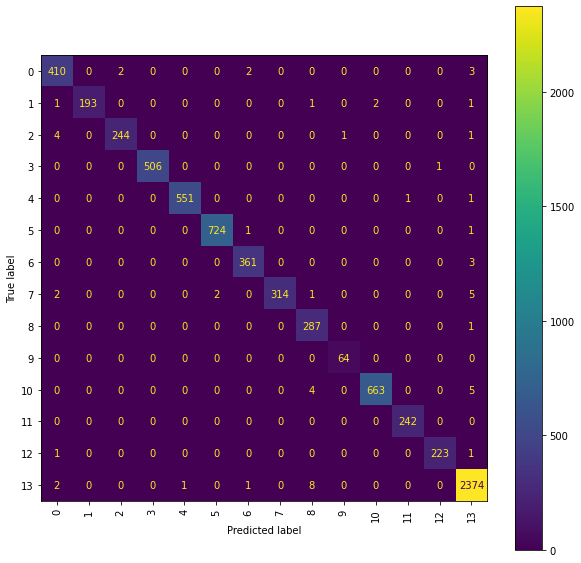

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay
# plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, xticks_rotation='vertical', ax=ax)

In [ ]:
print(test_labels.shape)
print(test_predictions.shape)

(7216,)
(7216,)


In [ ]:
print(accuracy_score(test_labels, test_predictions) )

0.1574279379157428


Grafici

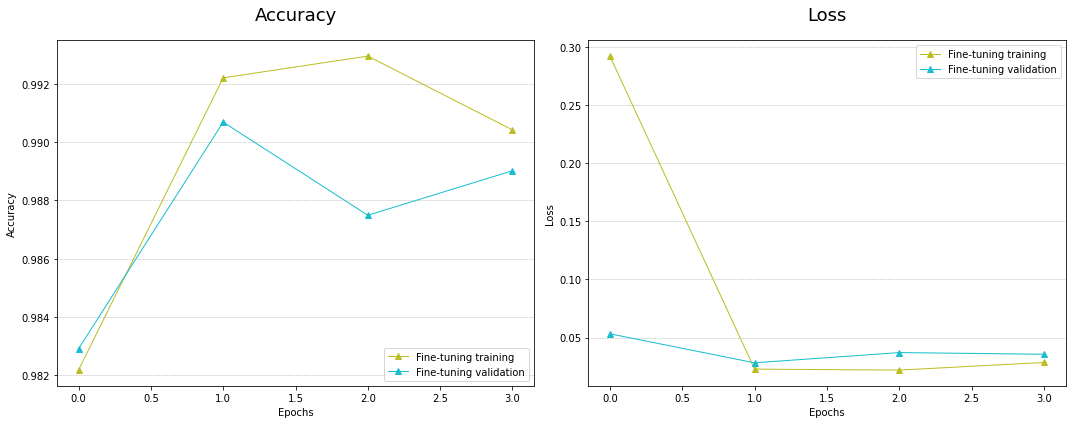

In [ ]:
# data from fine-tuning training
ft_acc = history.history['accuracy']
ft_val_acc = history.history['val_accuracy']
ft_loss = history.history['loss']
ft_val_loss = history.history['val_loss']

# create figure
fig, (acc_g,loss_g) = plt.subplots(1,2, figsize=(15,6))

# range for x axis
epochs_1 = range(len(ft_acc))

# plot accuracy curves
acc_g.plot(epochs_1, ft_acc, color='tab:olive', marker='^', linestyle='-', label='Fine-tuning training', linewidth=1)
acc_g.plot(epochs_1, ft_val_acc, color='tab:cyan', marker='^', linestyle='-', label='Fine-tuning validation', linewidth=1)

# plot loss curves
loss_g.plot(epochs_1, ft_loss, color='tab:olive', marker='^', linestyle='-', label='Fine-tuning training ', linewidth=1)
loss_g.plot(epochs_1, ft_val_loss, color='tab:cyan', marker='^', linestyle='-', label='Fine-tuning validation', linewidth=1)

# accuracy graph style options
acc_g.grid(axis='y', linestyle='--', linewidth=0.5)
acc_g.set_xlabel('Epochs')
acc_g.set_ylabel('Accuracy')
acc_g.set_title('Accuracy', fontdict={'fontsize':18}, pad=20)
acc_g.legend(loc='lower right')

# loss graph style options
loss_g.grid(axis='y', linestyle='--', linewidth=0.5)
loss_g.set_xlabel('Epochs')
loss_g.set_ylabel('Loss')
loss_g.set_title('Loss', fontdict={'fontsize':18}, pad=20)
loss_g.legend(loc='upper right')

# layout adjustment
plt.tight_layout()

# save graph
fig.savefig('train_plots.png')

# Dubbi da discutere insieme appassionatamente


*   Nel notebook viene fatta la load weights dal checkpoint
* Perchè Porcod non va questa confusion matrix del Dio ca
* 

